LOAD THE DATASET

In [1]:
import pandas as pd

df = pd.read_parquet("../data/processed/lendingclub.parquet")
print(f"{len(df):,} rows  |  {df.shape[1]} columns")

2,260,701 rows  |  151 columns


In [2]:
sample_df = df.sample(100_000, random_state=42)

In [3]:
# shape, dtypes, missing counts, memory
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 6.0 GB


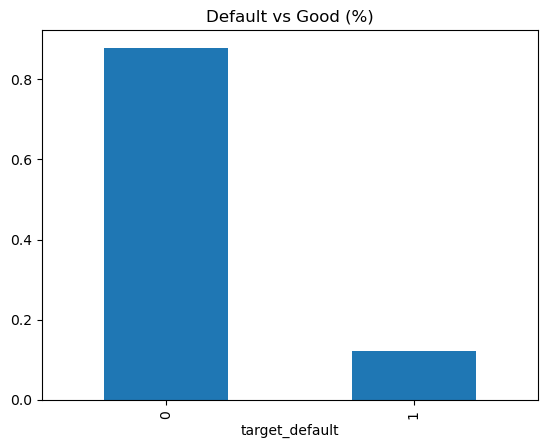

In [4]:
# Creating a clean binary target (0=good and 1=bad)
good_status  = ["Fully Paid", "Current"]
bad_status   = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"]

df = df[df["loan_status"].isin(good_status + bad_status)].copy()
df["target_default"] = df["loan_status"].isin(bad_status).astype(int)
df["target_default"].value_counts(normalize=True).plot.bar(title="Default vs Good (%)");

MISSING VALUE OVERVIEW

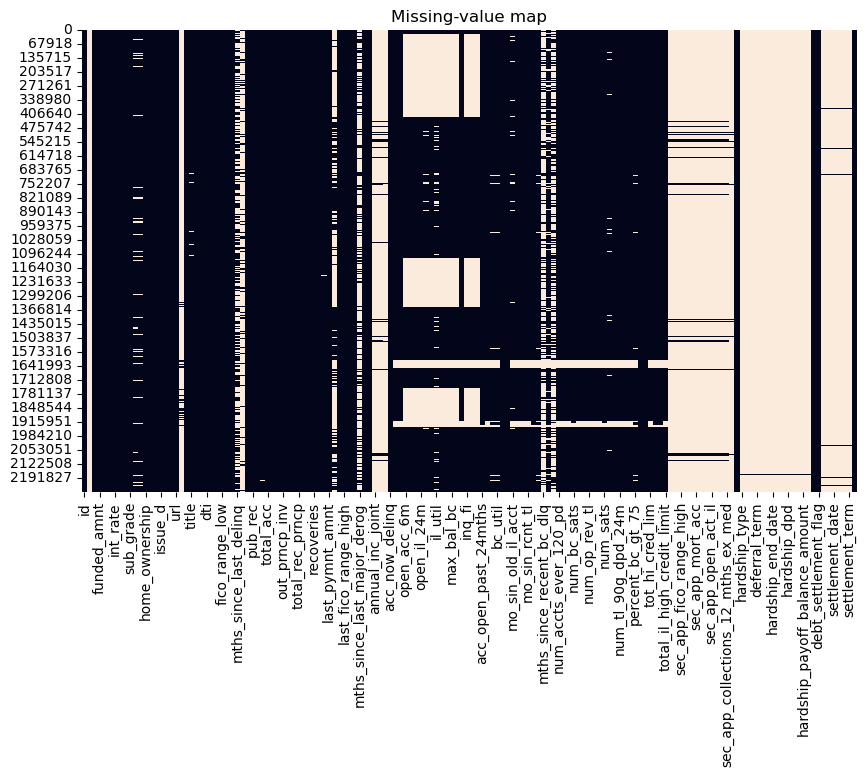

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing-value map"); plt.show()

In [6]:
missing_pct = df.isna().mean().sort_values(ascending=False)
drop_cols = missing_pct[missing_pct > 0.80].index      # Drop columns with >80 % missing
df = df.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} ultra-sparse columns.")

Dropped 39 ultra-sparse columns.


SEPARATE COLUMN TYPES(NUMERICAL & CATEGORICAL)

In [7]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(include="object").columns.tolist()
print(len(num_cols), "numeric   |", len(cat_cols), "categorical/text")

88 numeric   | 25 categorical/text


In [8]:
#For speed, cast obvious numeric-as-string columns
import numpy as np

maybe_pct_cols = ["int_rate", "revol_util", "annual_inc_joint"]

pct_cols = [col for col in maybe_pct_cols if col in df.columns]

for col in pct_cols:
    df[col] = (
        df[col]
        .astype(str)             # guarantees we have the .str accessor
        .str.rstrip("%")         # drops the % sign if it’s there
        .replace({"": np.nan, "nan": np.nan})
        .astype(float)
    )

print("Converted columns:", pct_cols)
print(df[pct_cols].head())

Converted columns: ['int_rate', 'revol_util']
   int_rate  revol_util
0     13.99        29.7
1     11.99        19.2
2     10.78        56.2
3     14.85        11.6
4     22.45        64.5


UNIVARIATE DISTRIBUTIONS

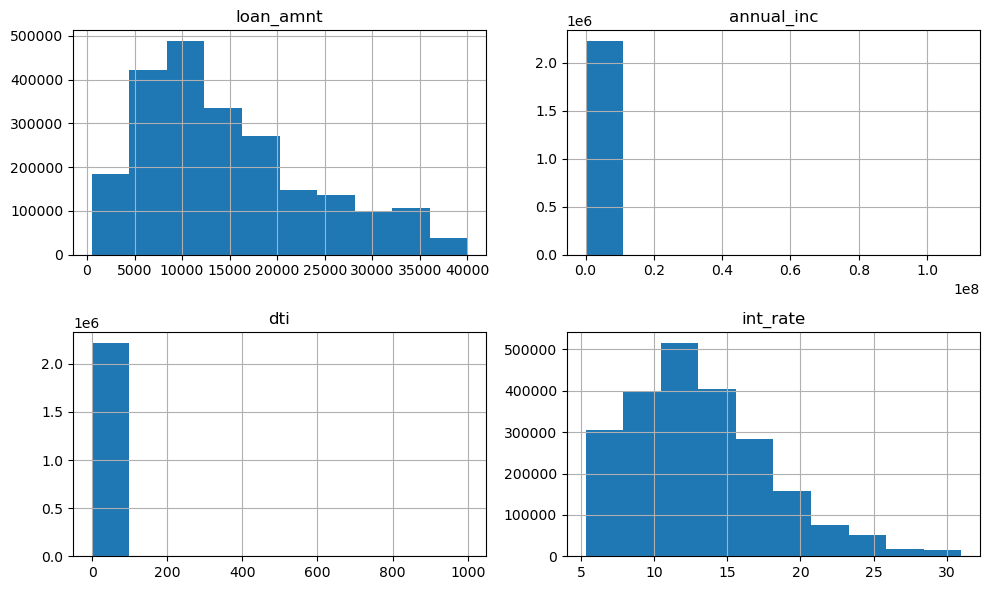

In [9]:
plot_cols = ["loan_amnt", "annual_inc", "dti", "int_rate"]
df[plot_cols].hist(figsize=(10,6)); plt.tight_layout(); plt.show()

#TIDY-UP THE COLUMNS 

In [ ]:
# annual_inc 
#Cap the top 1%
upper_inc = df['annual_inc'].quantile(0.99)   # ~99th percentile
df['annual_inc'] = df['annual_inc'].clip(upper=upper_inc)
df['annual_inc_log'] = np.log1p(df['annual_inc'])   # +1 to avoid log(0)

# dti
#Treat >60 as “missing”
df.loc[df['dti'] > 60, 'dti'] = np.nan
df['dti'] = df['dti'].fillna(df['dti'].median())

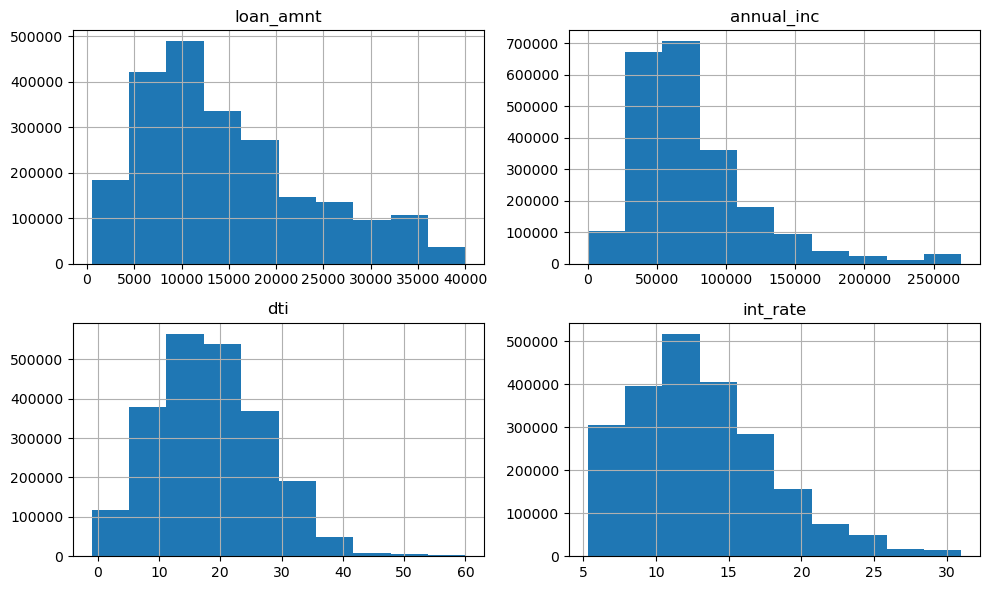

In [11]:
plot_cols = ["loan_amnt", "annual_inc", "dti", "int_rate"]
df[plot_cols].hist(figsize=(10,6)); plt.tight_layout(); plt.show()

CORRELATION HEATMAP

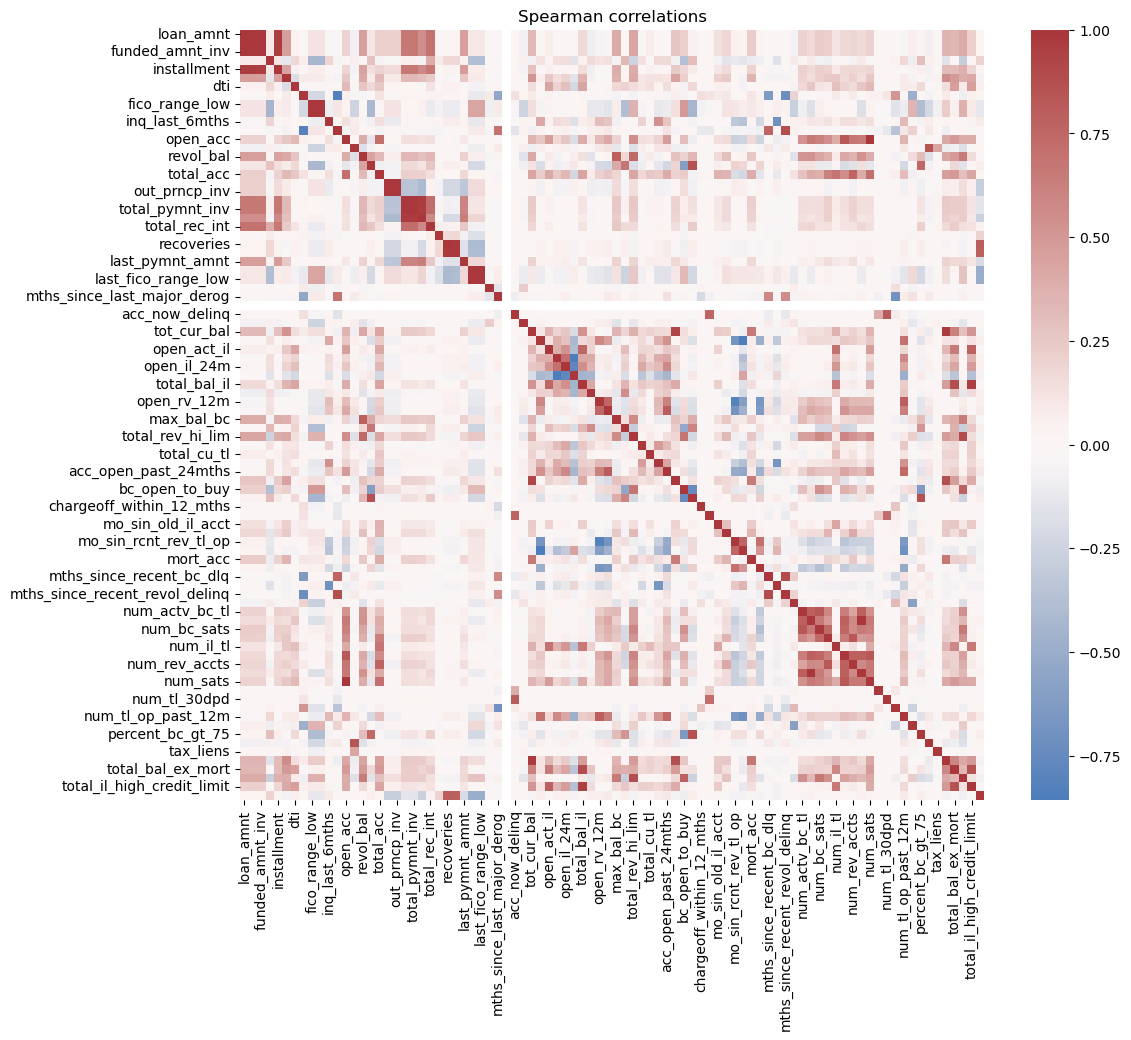

In [12]:
corr = df[num_cols].corr(method="spearman")
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="vlag", center=0); plt.title("Spearman correlations"); plt.show()

CATEGORICAL V/S TARGET

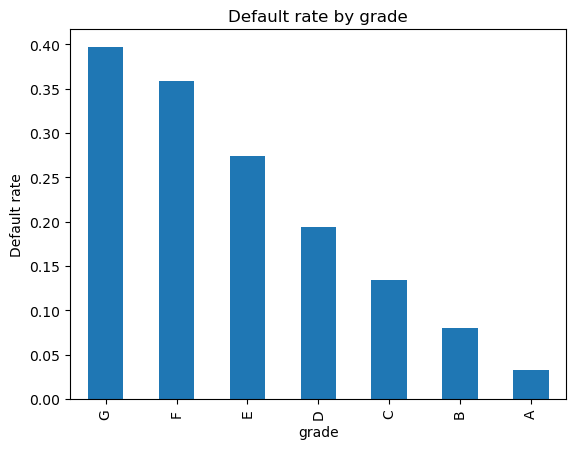

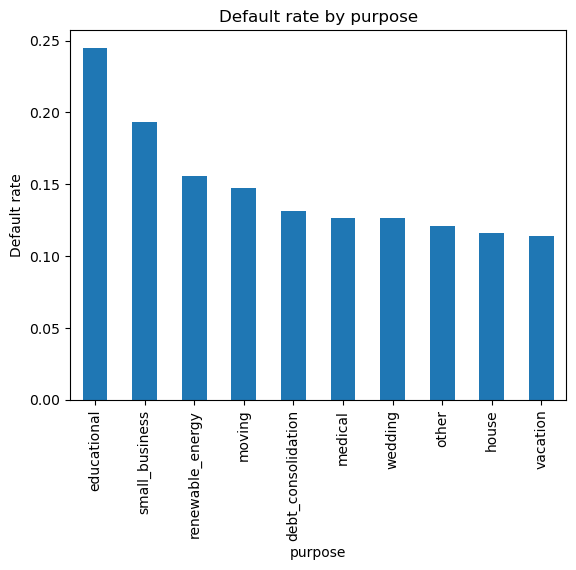

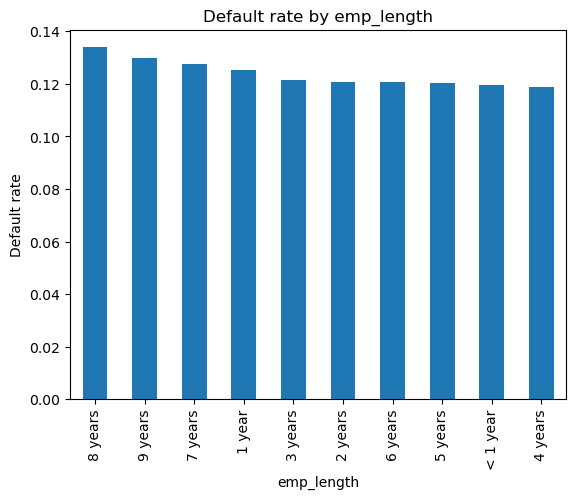

In [13]:
def plot_default_rate(cat_col, top_n=10):
    tmp = (df
           .groupby(cat_col)["target_default"]
           .mean()
           .sort_values(ascending=False)[:top_n])
    tmp.plot.bar()
    plt.ylabel("Default rate")
    plt.title(f"Default rate by {cat_col}")
    plt.show()

plot_default_rate("grade")
plot_default_rate("purpose")
plot_default_rate("emp_length")

TIME SERIES TREND

/var/folders/gp/8q236sds0115l0dr_wrbhszw0000gn/T/ipykernel_46218/3382660994.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample("Q")["target_default"]


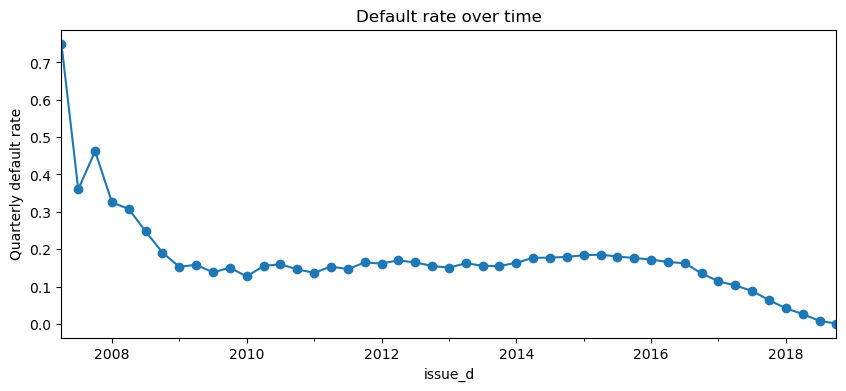

In [14]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y")
monthly = (df
           .set_index("issue_d")
           .resample("Q")["target_default"]
           .mean())

monthly.plot(figsize=(10,4), marker="o")
plt.ylabel("Quarterly default rate")
plt.title("Default rate over time")
plt.show()

SAVE THE CLEANED DATASET

In [16]:
df.to_parquet("../data/processed/lc_numeric_clean.parquet")
print("Clean numeric dataset saved.")

Clean numeric dataset saved.
